# **Assignment 15**

Use Random Forest to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"
 

In [68]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Import Dataset
df = pd.read_csv('/content/Fraud_check.csv')
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


# **Data Exploration**

In [70]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [71]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [72]:
df.shape

(600, 6)

In [73]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [74]:

df[df.duplicated()].shape

(0, 6)

In [75]:
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [76]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


# **Feature Engineering**

In [77]:
df['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [78]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


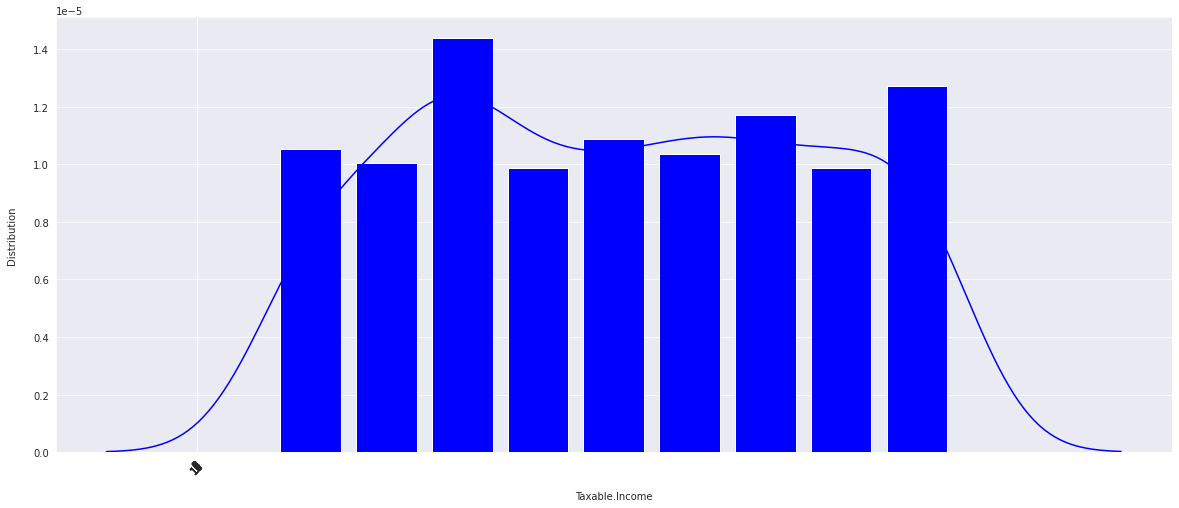

In [79]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [80]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [81]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   taxable_category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [82]:
categorical_features = df1.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')

In [83]:
numerical_features = df1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

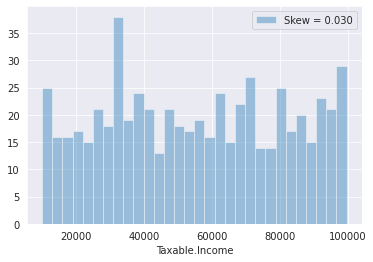

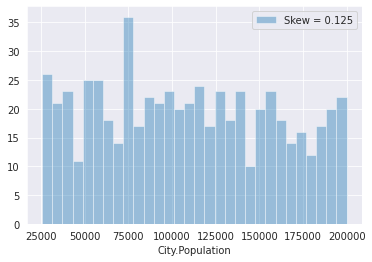

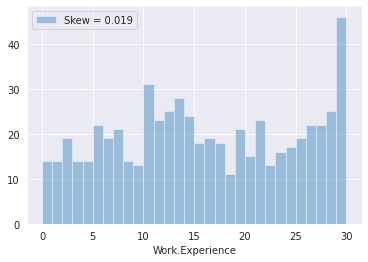

In [84]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [85]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 0 observations with more than 2 outliers


In [86]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

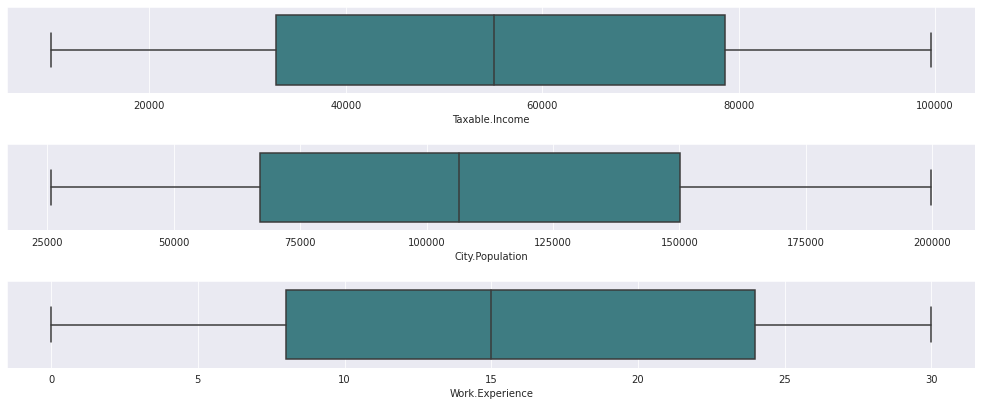

In [87]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

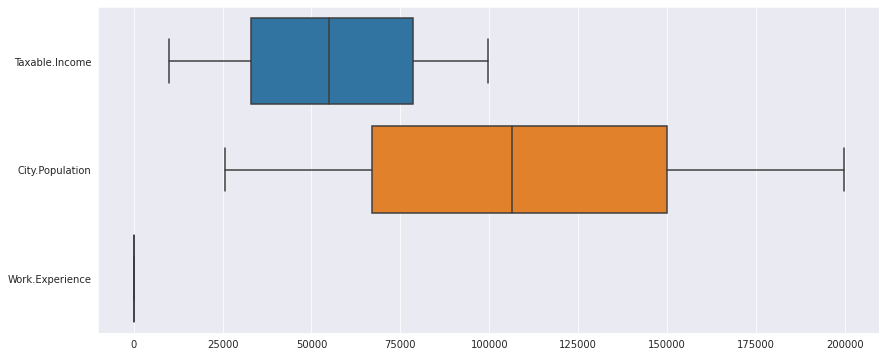

In [88]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h")

<Figure size 576x576 with 0 Axes>

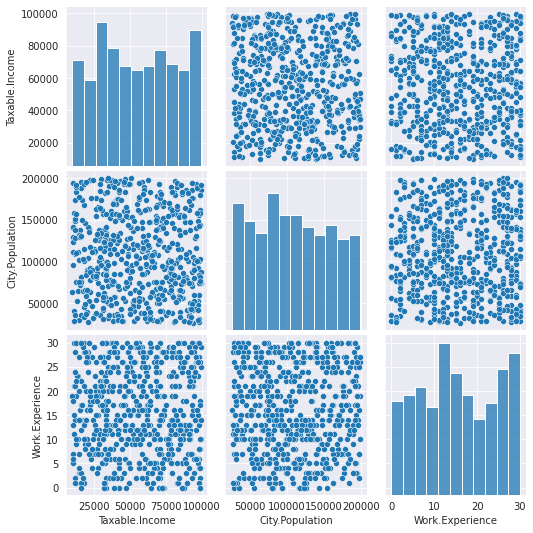

In [89]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

<AxesSubplot:>

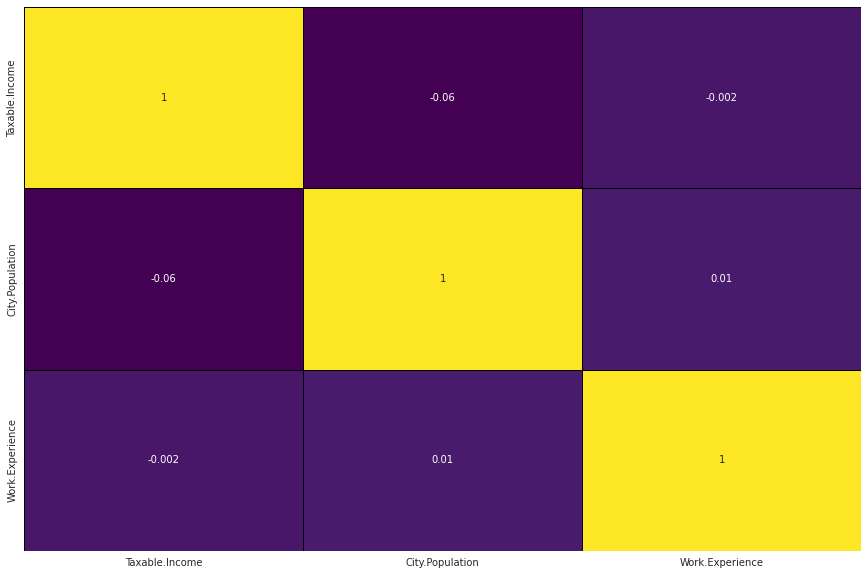

In [90]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')


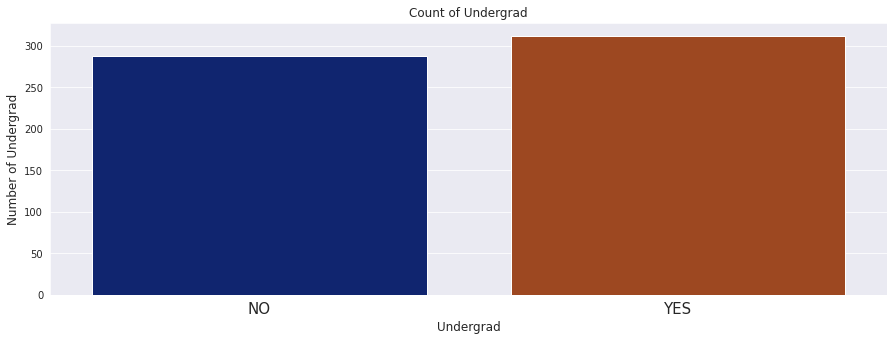

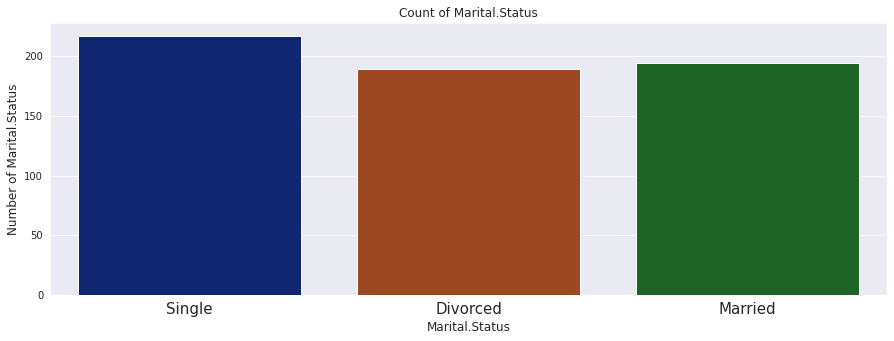

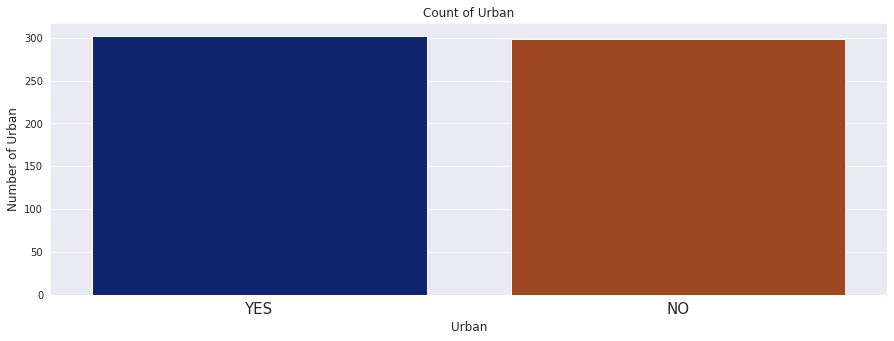

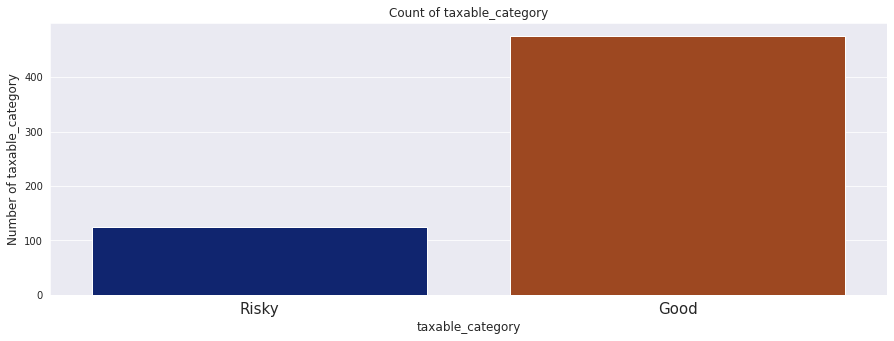

In [91]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

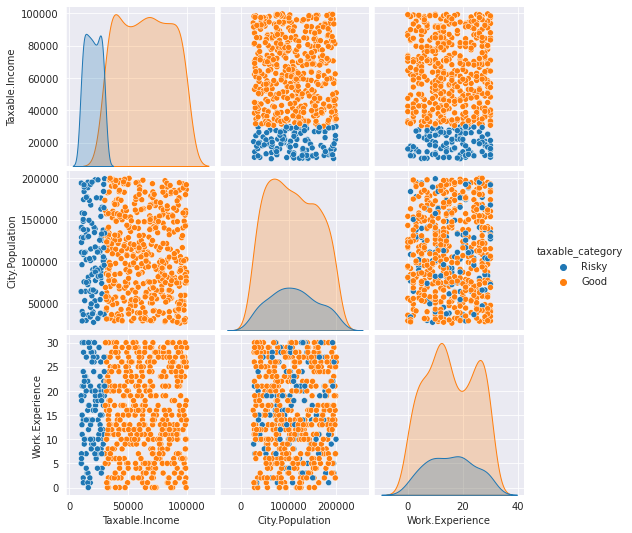

In [93]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

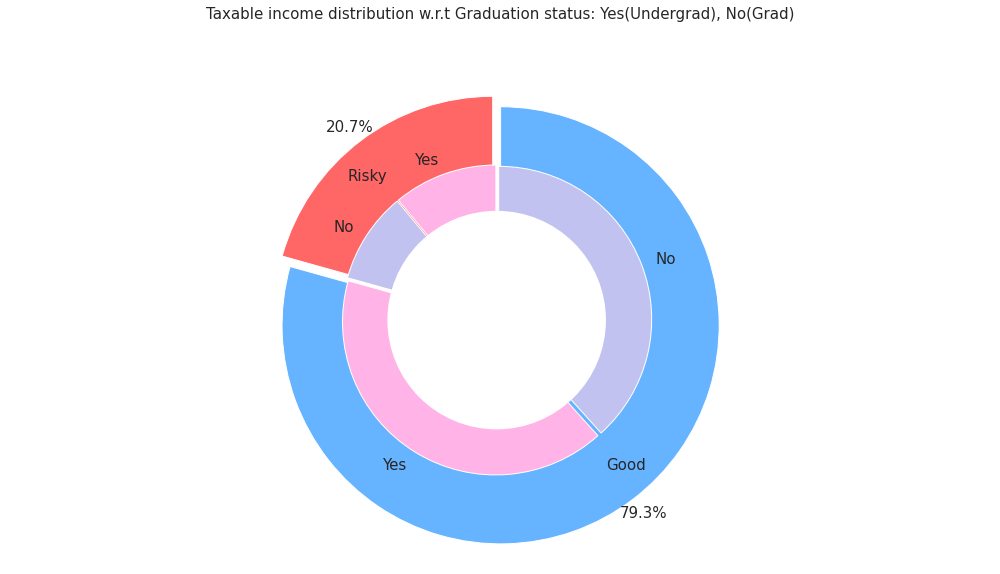

In [94]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Undergrad).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

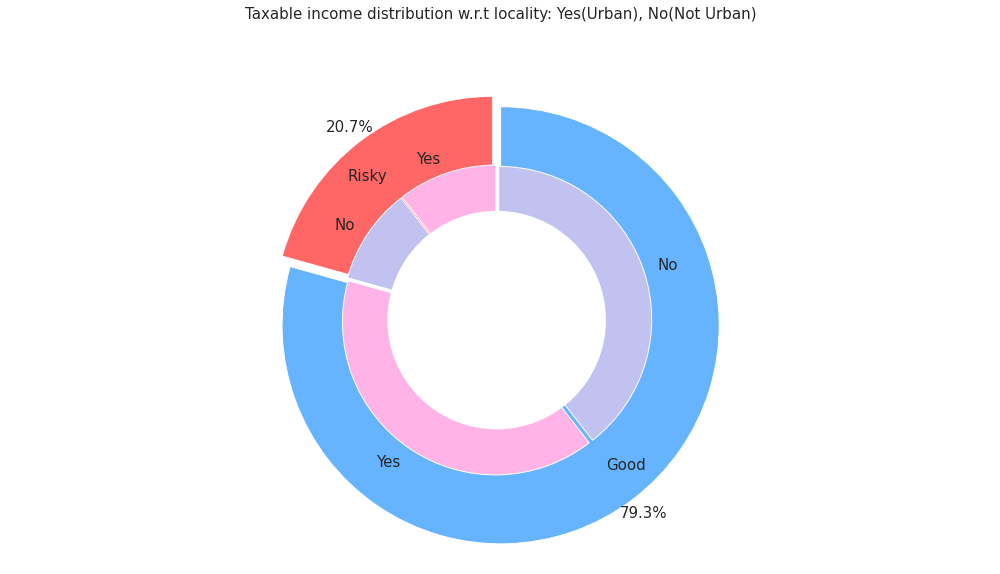

In [96]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Urban).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

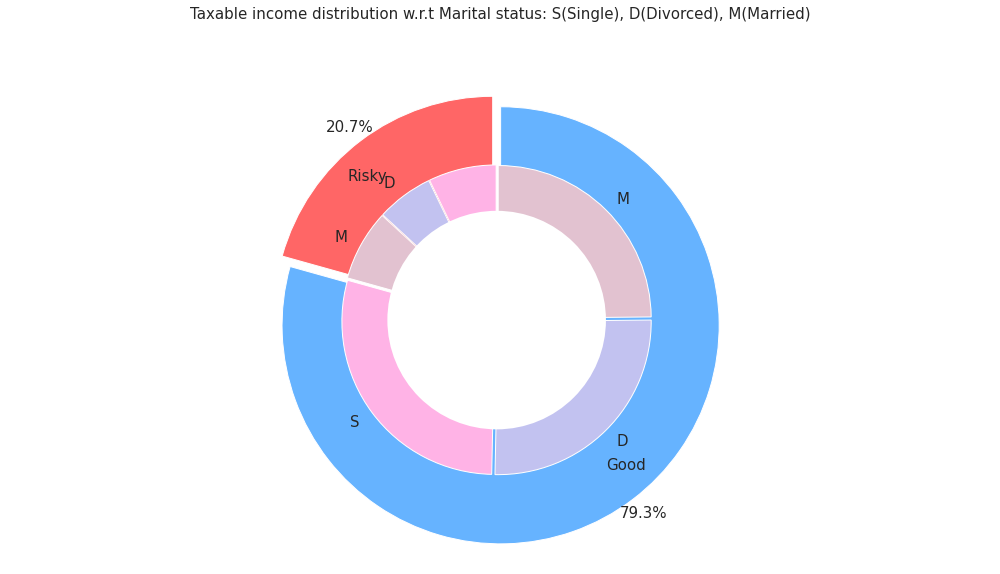

In [97]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1["Marital.Status"]).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [98]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


Text(0.5, 1.0, 'Correlation with Sales \n')

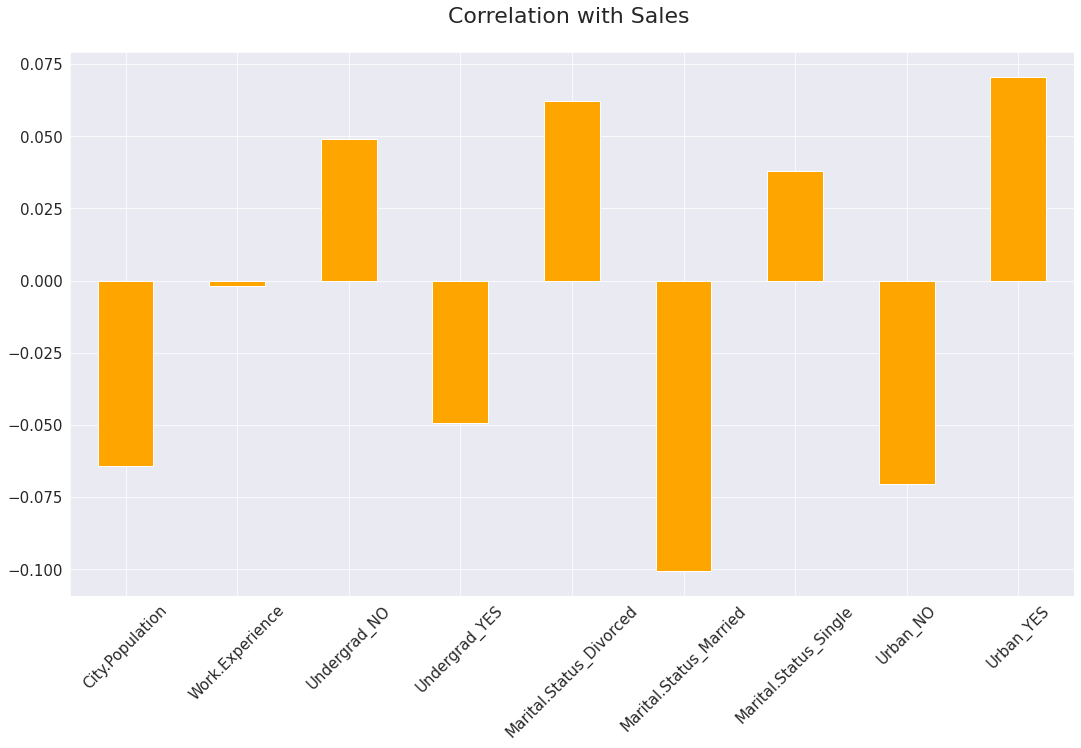

In [99]:
data2 = data_.copy()

correlations = data2.corrwith(df1['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

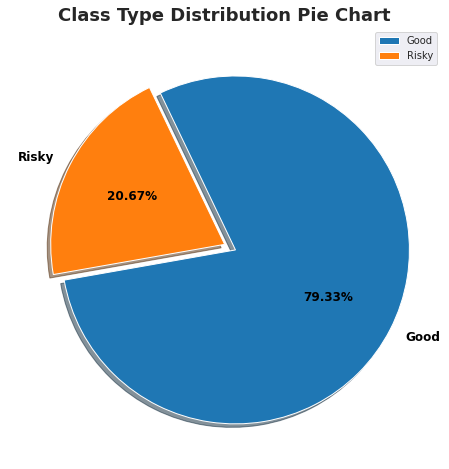

In [100]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

In [101]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [102]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

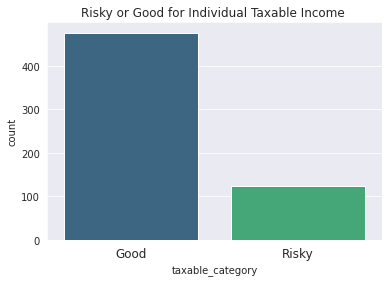

In [103]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

In [104]:
model_data = df1.copy()
model_data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
model_data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = model_data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [105]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(model_data[col])
        model_data[col] = le.transform(model_data[col])
model_data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [106]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [107]:
data_['Taxable_Income'] = df1.taxable_category
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good


In [108]:
le = LabelEncoder()
le.fit(data_["Taxable_Income"])
data_["Taxable_Income"]=le.transform(data_["Taxable_Income"])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [110]:
# split into input (X) and output (y) variables
X = data_.iloc[:, :-1]

y=  data_.Taxable_Income

In [111]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [114]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [115]:
# summarize scores
scores = fit.scores_

features = fit.transform(X)

In [116]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
0,2045.643886,City.Population
5,0.756912,Marital.Status_Married
4,0.302172,Marital.Status_Divorced
6,0.095850,Marital.Status_Single
2,0.048929,Undergrad_NO
3,0.045165,Undergrad_YES
1,0.011709,Work.Experience
7,0.007044,Urban_NO
8,0.006951,Urban_YES


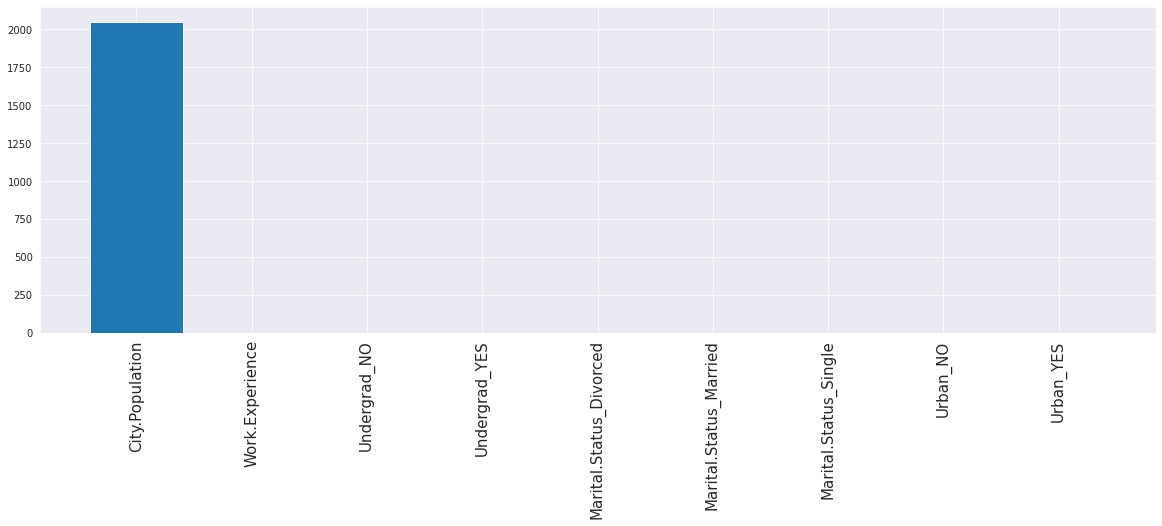

In [118]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

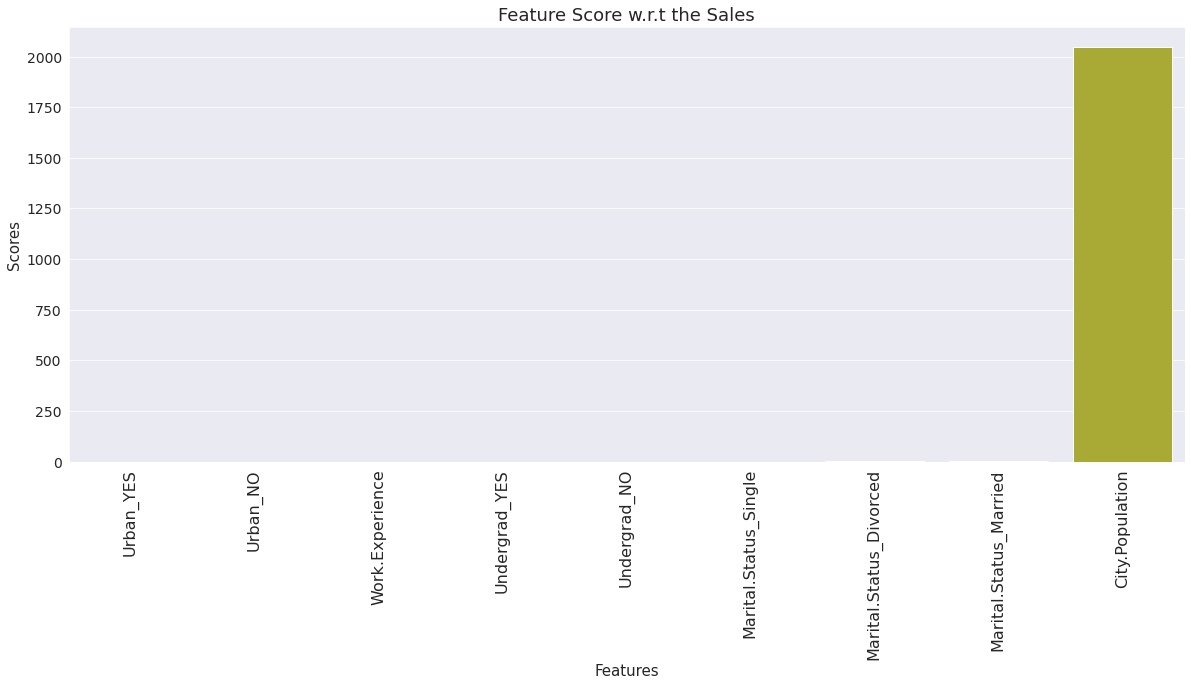

In [119]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

# **Random Forest Built-in Feature Importance**

In [120]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(X, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

checking the oob score 0.7933333333333333
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


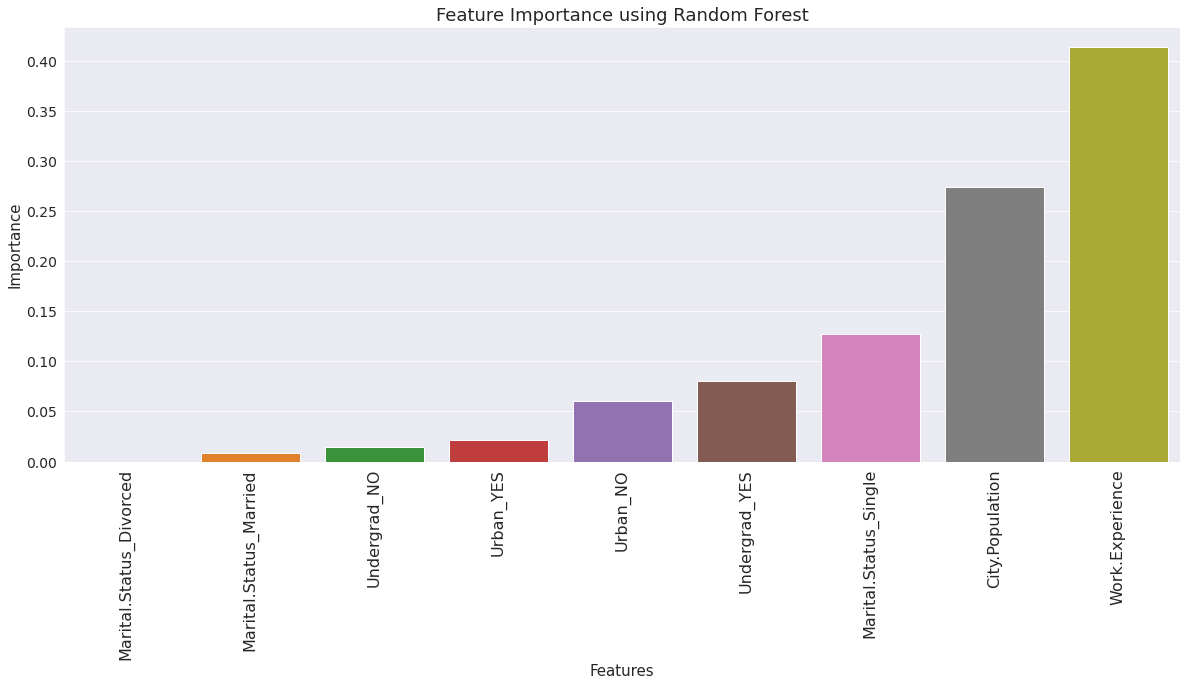

In [121]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

In [122]:
model_data.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'taxable_category'],
      dtype='object')

In [123]:
x = model_data.drop('taxable_category',axis=1)
y = model_data['taxable_category']

In [124]:
y.unique()

array([0, 1])

In [125]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
counter_train = Counter(train_y)
counter_test = Counter(test_y)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 429, 1: 111}) Testing Data Counter({0: 47, 1: 13})


In [126]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [127]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 333, 1: 87}) Testing Data Counter({0: 143, 1: 37})


In [128]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


In [129]:
x = model_data.drop(['taxable_category'], axis=1)
y = model_data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [130]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


# **Random Forest**

In [131]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [132]:
loc = np.array(score_array).max()
score_array.index(loc)+1

176

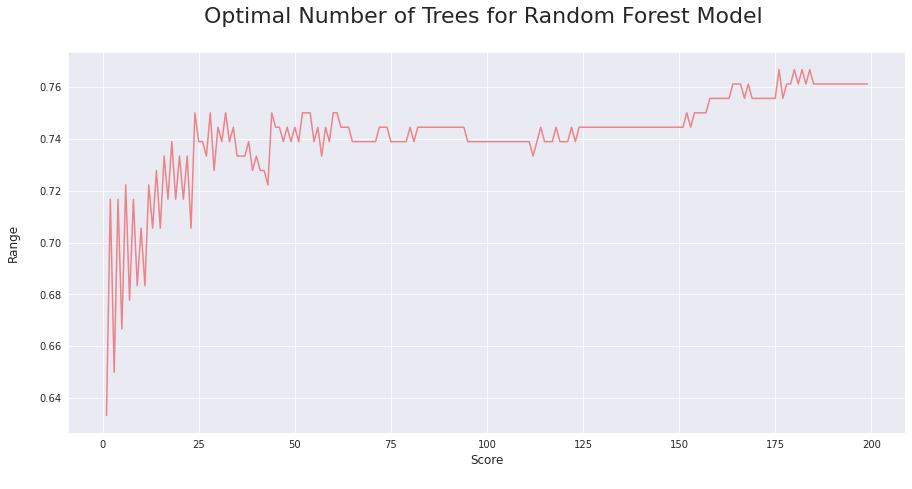

In [133]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [134]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=50, max_features='auto', min_samples_leaf=4,
                       n_estimators=195, random_state=42)

In [137]:
df1.taxable_category.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']